In [1]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from numpy import concatenate
from pandas import DataFrame
from math import sqrt

Using TensorFlow backend.


In [2]:
# The path to our CSV file
file = "../data/csv/Palladium_Data.csv"
df = pd.read_csv(file)
df.head()
postfitdf = df

In [3]:
#new = old.filter(['A','B','D'], axis=1)

df1 = df.filter(['Date','Palladium_Settle', 'Open Interest', 'Money Manager Shorts', 'Money Manager Longs', 'Producer/Merchant/Processor/User Longs', 'Producer/Merchant/Processor/User Shorts'], axis=1)

In [4]:
#raw_data['Mycol'] =  pd.to_datetime(raw_data['Mycol'], format='%d%b%Y:%H:%M:%S.%f')

df1['Date'] = pd.to_datetime(df1['Date'])
df1.set_index('Date', inplace = True)

In [5]:
df1.head()

,Palladium_Settle,Open Interest,Money Manager Shorts,Money Manager Longs,Producer/Merchant/Processor/User Longs,Producer/Merchant/Processor/User Shorts
Date,,,,,,
2006-06-13,312.540000,14355.0,1686.0,5375.0,891.0,7083.0
2006-06-20,296.800000,13681.0,1545.0,5138.0,955.0,7358.0
2006-06-27,311.090000,13149.0,2000.0,5360.0,881.0,7110.0
2006-07-03,316.566667,13423.0,2040.0,5734.0,871.0,7109.0
2006-07-11,328.080000,13895.0,2042.0,6219.0,848.0,7413.0


In [6]:
df1.corr()

,Palladium_Settle,Open Interest,Money Manager Shorts,Money Manager Longs,Producer/Merchant/Processor/User Longs,Producer/Merchant/Processor/User Shorts
Palladium_Settle,1.000000,0.531798,0.038943,0.552198,0.231504,0.260948
Open Interest,0.531798,1.000000,0.209181,0.946450,0.509374,0.823383
Money Manager Shorts,0.038943,0.209181,1.000000,0.076909,0.515238,-0.219328
Money Manager Longs,0.552198,0.946450,0.076909,1.000000,0.377223,0.810357
Producer/Merchant/Processor/User Longs,0.231504,0.509374,0.515238,0.377223,1.000000,0.236021
Producer/Merchant/Processor/User Shorts,0.260948,0.823383,-0.219328,0.810357,0.236021,1.000000


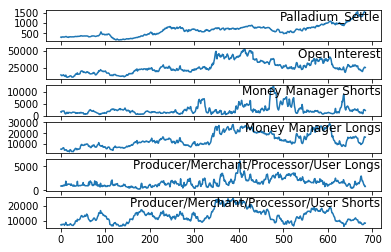

In [7]:
from matplotlib import pyplot
# load dataset
#dataset = read_csv('pollution.csv', header=0, index_col=0)
values = df1.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(df1.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [8]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
#dataset = read_csv('pollution.csv', header=0, index_col=0)
values = df1.values
# integer encode direction
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[7,8,9,10,11]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var1(t)
1   0.101312   0.084123   0.093948   0.095326   0.109963   0.055621  0.089964
2   0.089964   0.068070   0.081862   0.086172   0.120807   0.069719  0.100267
3   0.100267   0.055399   0.120864   0.094747   0.108268   0.057005  0.104215
4   0.104215   0.061925   0.124293   0.109193   0.106574   0.056954  0.112516
5   0.112516   0.073167   0.124464   0.127926   0.102677   0.072538  0.111723


In [9]:

# split into train and test sets
values = reframed.values
n_train_days = int(len(df1)*.75)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(513, 1, 6) (513,) (171, 1, 6) (171,)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 513 samples, validate on 171 samples
Epoch 1/125
 - 2s - loss: 0.2272 - acc: 0.0019 - val_loss: 0.4542 - val_acc: 0.0000e+00
Epoch 2/125
 - 0s - loss: 0.1511 - acc: 0.0019 - val_loss: 0.3582 - val_acc: 0.0000e+00
Epoch 3/125
 - 0s - loss: 0.0868 - acc: 0.0019 - val_loss: 0.2672 - val_acc: 0.0000e+00
Epoch 4/125
 - 0s - loss: 0.0672 - acc: 0.0019 - val_loss: 0.2190 - val_acc: 0.0000e+00
Epoch 5/125
 - 0s - loss: 0.0705 - acc: 0.0019 - val_loss: 0.2140 - val_acc: 0.0000e+00
Epoch 6/125
 - 0s - loss: 0.0691 - acc: 0.0019 - val_loss: 0.2262 - val_acc: 0.0000e+00
Epoch 7/125
 - 0s - loss: 0.0669 - acc: 0.0019 - val_loss: 0.2302 - val_acc: 0.0000e+00
Epoch 8/125
 - 0s - loss: 0.0640 - acc: 0.0019 - val_loss: 0.2254 - val_acc: 0.0000e+00
Epoch 9/125
 - 0s - loss: 0.0624 - acc: 0.0019 - val_loss: 0.2225 - val_acc: 0.0000e+00
Epoch 10/125
 - 0s - loss: 0.0611 - acc: 0

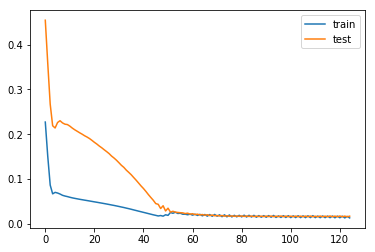

In [10]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
# fit network
history = model.fit(train_X, train_y, epochs=125, batch_size=48, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [11]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                11400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 11,451
Trainable params: 11,451
Non-trainable params: 0
_________________________________________________________________


In [12]:

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 32.799


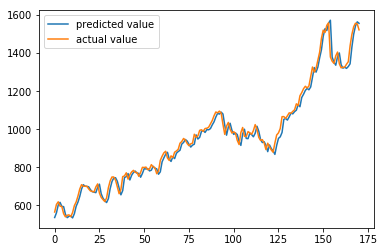

In [13]:
pyplot.plot(inv_yhat, label="predicted value")
pyplot.plot(inv_y, label="actual value")
pyplot.legend()
pyplot.show()

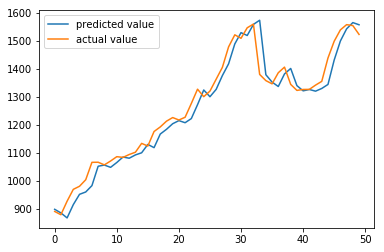

In [14]:
pyplot.plot(inv_yhat[-50:], label="predicted value")
pyplot.plot(inv_y[-50:], label="actual value")
pyplot.legend()
pyplot.show()

In [15]:
inv_yhat[len(inv_yhat)-2]

1564.3461

In [16]:
inv_y[len(inv_y)-1]

1522.2399

In [17]:
# The path to our CSV file
file2 = "../data/csv/PalladiumPrices.csv"
df3 = pd.read_csv(file2)
df4 = df3.filter(['Date','Settle'])
df4['Date'] = pd.to_datetime(df4['Date'])
RelVal = inv_yhat.tolist()
RelVal.reverse()
WklyDate = postfitdf['Date'].iloc[::-1].tolist()
z = {'Date': WklyDate, 'Relative Value': RelVal}
df5 = pd.concat([pd.Series(v, name=k) for k, v in z.items()], axis=1)
df5['Date'] = pd.to_datetime(df5['Date'])

PredictDF = pd.merge(df4, df5, on='Date', how='outer')
FinalPredict_DF = PredictDF.head(len(test_y))
FinalPredict_DF2 = FinalPredict_DF.fillna(method='bfill')

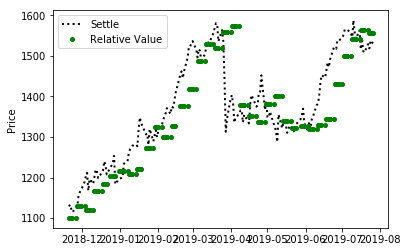

In [18]:
fig = pyplot.figure()
host = fig.add_subplot(111)
host.set_ylabel('Price')

line1, = host.plot(FinalPredict_DF2['Date'], FinalPredict_DF2['Settle'], color='black', linestyle='dotted', linewidth=2)
line2, = host.plot(FinalPredict_DF2['Date'], FinalPredict_DF2['Relative Value'], 'go', markersize=4)
host.legend([line1, line2], ['Settle', 'Relative Value'])

host.xaxis_date()
pyplot.show()

In [19]:
FinalPredict_DF2.head(10)

,Date,Settle,Relative Value
0,2019-07-26,1531.0,1556.634155
1,2019-07-25,1533.9,1556.634155
2,2019-07-24,1538.5,1556.634155
3,2019-07-23,1518.6,1556.634155
4,2019-07-22,1529.2,1564.346069
5,2019-07-19,1508.3,1564.346069
6,2019-07-18,1511.9,1564.346069
7,2019-07-17,1543.2,1564.346069
8,2019-07-16,1516.3,1564.346069
9,2019-07-15,1562.9,1542.068359


In [20]:
for i in range(len(FinalPredict_DF2.index)-3):
    FinalPredict_DF2.at[i,"Relative Value"] = FinalPredict_DF2["Relative Value"][i+3]
FinalPredict_DF2 = FinalPredict_DF2.iloc[:len(FinalPredict_DF2.index)-3]

FinalPredict_DF2.head(20)

,Date,Settle,Relative Value
0,2019-07-26,1531.0,1556.634155
1,2019-07-25,1533.9,1564.346069
2,2019-07-24,1538.5,1564.346069
3,2019-07-23,1518.6,1564.346069
4,2019-07-22,1529.2,1564.346069
5,2019-07-19,1508.3,1564.346069
6,2019-07-18,1511.9,1542.068359
7,2019-07-17,1543.2,1542.068359
8,2019-07-16,1516.3,1542.068359
9,2019-07-15,1562.9,1542.068359


In [21]:
#only_fridays = [i for i in range(0,len(FinalPredict_DF2.index)+1,5)]
#weekly = FinalPredict_DF2.iloc[only_fridays]
#weekly.head(10)

weekly = FinalPredict_DF2.loc[[True if day.weekday() == 4 else False for day in FinalPredict_DF2["Date"]]]
weekly.head()

,Date,Settle,Relative Value
0,2019-07-26,1531.0,1556.634155
5,2019-07-19,1508.3,1564.346069
10,2019-07-12,1542.4,1542.068359
15,2019-07-05,1564.2,1430.861084
19,2019-06-28,1537.6,1430.861084


C:\Users\omara\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\omara\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\omara\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

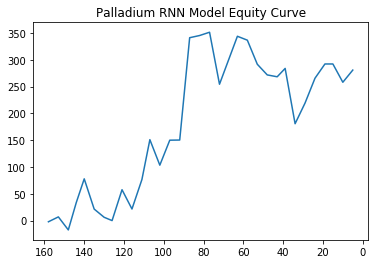

In [22]:
weekly['Settle Delta'] = weekly['Settle'].diff(+1)
weekly['Settle Delta'] = weekly['Settle Delta'].apply(lambda x:x*-1)
weekly['Rel Val Delta'] = weekly['Relative Value'].diff(-1)

Signal = np.sign(weekly['Rel Val Delta'])
weekly2 = pd.concat([weekly, pd.DataFrame(Signal)], axis=1)
weekly2.columns = ['Date', 'Settle', 'Relative Value', 'Settle Delta', 'Rel Val Delta', 'Signal']

weekly2['Profit'] = weekly2['Settle Delta']*weekly2['Signal']
weekly2['EC'] = weekly2.Profit[::-1].cumsum()
fig = plt.figure()
ax = weekly2['EC'].plot(title='Palladium RNN Model Equity Curve')
ax.invert_xaxis()
fig.savefig('../graphs/PALLADIUM_DL_EC.png')